# Metodo de montercarlo para optimización de portfolios

**Hay que tener en cuenta que siempre usamos datos pasados, y no tienen porque predecir el futuro**

https://towardsdatascience.com/efficient-frontier-in-python-detailed-tutorial-84a304f03e79

### ¿Qué necesitamos para simular carteras con Montecarlo?

- Tener los datos de las cotizaciones de los stocks que queramos tener en cartera
- Generar carteras de manera aletoria

In [65]:
!pip install yfinance

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Datos historicos
import yfinance as yf

In [2]:
tickers = ['AAPL','VZ','MMM']# 'STR'

- Vamos a usar yfinance para decargar los datos, mas info en https://pypi.org/project/yfinance/

In [15]:
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = tickers,

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "2y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'column',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    ).Close

[*********************100%***********************]  4 of 4 completed


In [16]:
data

,AAPL,CSCO,MMM,VZ
Date,,,,
2020-09-03,119.438210,38.575165,155.105637,55.310349
2020-09-04,119.517242,38.452709,154.602005,55.191715
2020-09-08,111.474350,37.680267,152.177170,54.717190
2020-09-09,115.920677,37.802727,154.536697,54.790192
2020-09-10,112.136345,37.275200,152.158524,54.324780
...,...,...,...,...
2022-08-29,161.380005,45.709999,126.440002,43.330002
2022-08-30,158.910004,45.240002,124.860001,42.529999
2022-08-31,157.220001,44.720001,124.349998,41.810001


### Generación de carteras

El primer paso sería hacer una funcion que nos generase pesos aleatorios


In [17]:
def pesos(n_activos,n_simulaciones):
    w = np.random.random((n_simulaciones,n_activos))
    w = w / w.sum(axis=1).reshape(-1,1)
    return w
    

El segundo paso es calcular el ratio de sharpe de cada cartera


In [18]:
def rent_activos(data):
    rent = np.log(data).diff()
    return rent.iloc[1:,:]

In [19]:
def cov_matrix(data):
    cov = np.cov(data.T)
    return cov

In [20]:
def rent_diaria(data):
    precio_inicial = data.iloc[0,:]
    precio_final = data.iloc[-1,:]
    rent = np.log(precio_final/precio_inicial)/ data.shape[0]
    return rent

In [21]:
def sharpe(data,matriz_pesos):
    rent_carteras = rent_diaria(data).values * matriz_pesos
    rent_carteras = rent_carteras.sum(axis=1)
    matrix_cov = cov_matrix(data)

    riesgo_carteras = np.sqrt(np.dot(np.dot(matriz_pesos,matrix_cov),matriz_pesos.T).sum(axis=1))
    

    posiciones_0entre0 = (rent_carteras==0) * (riesgo_carteras==0)
    riesgo_carteras[posiciones_0entre0] = 0.0000001
    ratio_sharpe = rent_carteras / riesgo_carteras

    return ratio_sharpe, rent_carteras, riesgo_carteras

In [22]:
def montecarlo(data,n_simulaciones):
    num_bloques = int(np.ceil(n_simulaciones/10000))
    rent_carteras_total = []
    riesgo_carteras_total = []
    
    for bloque in range(num_bloques):
        print(f'{bloque+1}/{num_bloques}')
        # Generamos una matriz de pesos aleatorios
        matriz_pesos = pesos(n_activos=data.shape[1],n_simulaciones=10000)
        # Calculamos la rentabilidad de cada cartera y sus ratios de sharpe
        ratio_sharpe, rent_carteras, riesgo_carteras = sharpe(data,matriz_pesos)

        # Guardamos la rentabilidad de cada cartera y su riesgo
        rent_carteras_total.append(rent_carteras)
        riesgo_carteras_total.append(riesgo_carteras)
        
        # Obtenemos el ratio de sharpe más alto
        max_eficiencia = ratio_sharpe.max()
        if bloque == 0:
            print(f'Nueva eficiencia: {max_eficiencia}')
            posicion_cartera_eficiente = np.where(ratio_sharpe == max_eficiencia)[0]
            # Obtenemos la cartera con mejor ratio de sharpe
            cartera_eficiente = pd.DataFrame(
                matriz_pesos[posicion_cartera_eficiente,:],
                columns=data.columns)
            eficiencia_inicial = max_eficiencia 

        if max_eficiencia > eficiencia_inicial:
            print(f'Nueva eficiencia: {max_eficiencia}')
            posicion_cartera_eficiente = np.where(ratio_sharpe == max_eficiencia)[0]
            # Obtenemos la cartera con mejor ratio de sharpe
            cartera_eficiente = pd.DataFrame(
                matriz_pesos[posicion_cartera_eficiente,:],
                columns=data.columns)
            # Guardamos la mejor eficiencia y la cartera
            eficiencia_inicial = max_eficiencia          

    plt.scatter(riesgo_carteras,rent_carteras,c=ratio_sharpe)
    plt.ylabel('Rentabilidad')
    plt.xlabel('Riesgo')

    return cartera_eficiente, eficiencia_inicial
    
    

1/100
Nueva eficiencia: 5.107605316624732e-07
2/100
Nueva eficiencia: 5.151875198203379e-07
3/100
4/100
Nueva eficiencia: 5.224507691204934e-07
5/100
6/100
Nueva eficiencia: 5.300235681530343e-07
7/100
8/100
9/100
10/100
Nueva eficiencia: 5.320859837037378e-07
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
Nueva eficiencia: 5.47016162308248e-07
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
Nueva eficiencia: 5.483183183091307e-07
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100
100/100
      AAPL      CSCO       MM

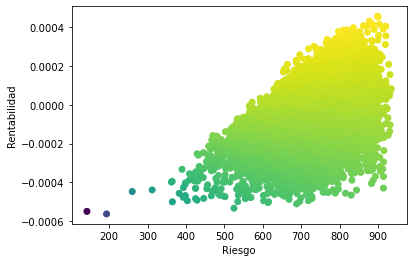

In [23]:
cartera_eficiente, max_eficiencia = montecarlo(data,n_simulaciones=1000000)
print(cartera_eficiente)
print(max_eficiencia)